<a href="https://colab.research.google.com/github/elaysason/Crypto-Exp3/blob/main/lemida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import random
from operator import itemgetter
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict

In [45]:
coins_list = ["BinanceCoin", "Bitcoin", "Cardano", "ChainLink", "CryptocomCoin", "Dogecoin", "EOS",
              "Ethereum", "Iota", "Litecoin", "Monero", "NEM", "Stellar", "Tether",
              "Tron", "USDCoin", "WrappedBitcoin", "XRP"]
K = 18
epsilon = [1 / K]
t = 0
T = 2991

reward_sum = dict()


In [4]:
crypto_datasets = dict()
for c in coins_list:
    file = "coin_" + c + ".csv"
    crypto = pd.read_csv(file)
    crypto['Date'] = pd.to_datetime(crypto['Date']).dt.date
    crypto_datasets[c] = crypto
    reward_sum[c] = 0

In [5]:
def get_date(start_date, days):
    return start_date + datetime.timedelta(days=days)

In [6]:
def payoff(coin, start_date, t, amountToInvest=1.0):
    date = get_date(start_date, t).date()
    on_date = crypto_datasets[coin].loc[crypto_datasets[coin]["Date"] == date]
    if len(on_date) == 0:
        before_date = crypto_datasets[coin].loc[crypto_datasets[coin]["Date"] < date].sort_values(by=["Date"],ascending=False)
        open = before_date['Open'].head(20).mean()
        close = before_date['Close'].head(20).mean()
        return amountToInvest*close/open - amountToInvest

    sharesBought = amountToInvest / pd.to_numeric(on_date['Open'])
    amountAfterSale = list(pd.to_numeric(sharesBought) * pd.to_numeric(on_date['Close']))[0]

    return amountAfterSale - amountToInvest

In [7]:
def get_existing_coins(start_date, days):
    existing = []
    new = []
    for i, key in enumerate(crypto_datasets.keys()):
        if min(crypto_datasets[key]["Date"]) <= get_date(start_date, days).date():
            existing.append(i)
    return existing

In [10]:
def choose_coin(coin_value_list):
    coins = [tup[0] for tup in coin_value_list]
    probs = [float(tup[1]) for tup in coin_value_list]
    return random.choices(coins, weights=probs)[0]

In [51]:
def exp3_base(date, days):
    eta = np.sqrt(np.log(K) / (days* K))
    start_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    scores = [0] * K
    reward_sum = 0
    for t in range(1, days):
        cur_distribution = []
        sum_scores = np.sum([np.exp(s * eta) for s in scores])
        for i in range(K):
            cur_distribution.append(
                np.exp(eta * scores[i]) / sum_scores)
        coins_values = [(coin, cur_distribution[coin]) for coin in range(K)]
        chosen_coin = choose_coin(coins_values)
        cur_reward = payoff(coins_list[chosen_coin], start_date, t)
        for i in range(K):
            scores[i] = scores[i] + 1
            if chosen_coin == i:
                scores[i] -= (1 - cur_reward) / cur_distribution[i]
        reward_sum += cur_reward * cur_distribution[chosen_coin]
    return reward_sum


In [49]:
def exp3_extension1(date, days):
    epsilon = [1 / K]
    start_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    rewards = []
    scores = [0] * K
    reward_sum = 0
    for t in range(1, days):
        epsilon.append(min([epsilon[0], math.sqrt(np.log(K) / (K * t))]))
        cur_distribution = []
        sum_scores = sum([math.exp(epsilon[t - 1] * s) for s in scores])
        for i in range(K):
            cur_distribution.append(1 - K * epsilon[t])
            val = math.exp(epsilon[t - 1] * scores[i]) / sum_scores
            cur_distribution[i] *= val
            cur_distribution[i] += epsilon[t]
            
        coins_values = [(coin, cur_distribution[coin]) for coin in range(K)]
        chosen_coin = choose_coin(coins_values)
        cur_reward = payoff(coins_list[chosen_coin], start_date, t)
        scores[chosen_coin] += (cur_reward) / cur_distribution[chosen_coin]
        reward_sum += cur_reward * cur_distribution[chosen_coin]
    return reward_sum


In [67]:
def exp3_extension2(date, days, conf_param):
    epsilon = [1 / K]
    reward_sum = defaultdict(int)
    start_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    epsilon[0] = 1 / K
    rho = dict()
    rewards = []
    to_remove = set()  #every coin that once was removed
    A = coins_list
    B = 4*(math.exp(1)-2)*(2*math.log(K)+math.log(2/conf_param))
    V = defaultdict(lambda: 1/K)  #1/K
    for t in range(1, days):
        epsilon.append(min([epsilon[0], math.sqrt(np.log(K) / (K * t))]))
        for coin in A:
            rho[coin] = (1-len(A)*epsilon[t])
            rho[coin] *= math.exp(epsilon[t-1]*reward_sum[coin]) / sum(math.exp(epsilon[t-1]*reward_sum[c]) for c in A)
            rho[coin] += epsilon[t]
            V[coin] += 1/rho[coin]
        coins_values = [(coin, rho[coin]) for coin in A]
        chosen_coin = choose_coin(coins_values)
        reward = payoff(chosen_coin, start_date, t) * rho[chosen_coin]
        reward_sum[chosen_coin] += reward / rho[chosen_coin]
        rewards.append(reward)
        best_coin = max(reward_sum, key=reward_sum.get)
        for c in A:
            if reward_sum[best_coin] - reward_sum[c] > math.sqrt(B*(V[best_coin] + V[c])):
                to_remove.add(c)
                reward_sum.pop(c)
                rho.pop(c)
        A = list(set(A) - set(to_remove))  #making sure that none of the coins that were removed remain in A
    return sum(rewards)

In [14]:
def payoff_to_day(coin,start_date,day):
    return sum([payoff(coin,start_date,i) for i in range(day)])

In [15]:
def get_best_coin_sum(date, days):
    start_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    best_sum = -float("inf")
    best_coin = list(crypto_datasets.keys())[0]
    for coin in crypto_datasets.keys():
        reward_sum = 0
        for t in range(days):
            reward_sum += payoff(coin, start_date, t)
        if reward_sum >= best_sum:
            best_coin = coin
            best_sum = reward_sum

In [52]:
days = range(1, 885, 5)
rewards_extended = [exp3_extension1('2019-02-1', i) for i in days]
rewards_basis = [exp3_base('2019-02-1', i) for i in days]
rewards_extended2 = [exp3_extension2('2019-02-1', i,0.3) for i in days]
best_coin_rewards = [get_best_coin_sum("2019-02-1", i) for i in days]
best_rewards = [r[1] for r in best_coin_rewards]

regrets_extended = [best_rewards[i] - rewards_extended[i] for i in range(len(days))]
regrets_basis = [best_rewards[i] - rewards_basis[i] for i in range(len(days))]
regrets_extended2 = [best_rewards[i] - rewards_extended2[i] for i in range(len(days))]


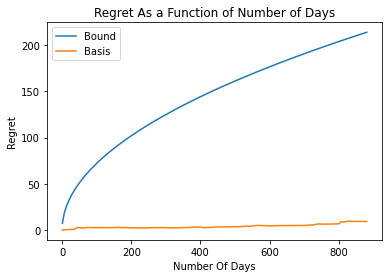

In [79]:
plt.plot(days,[np.sqrt(np.log(K) * (day* K)) for day in days],label='Bound')
plt.plot(days, regrets_extended, label='Basis')
plt.ylabel('Regret')
plt.xlabel('Number Of Days')
plt.title('Regret As a Function of Number of Days')
plt.legend()
plt.show()

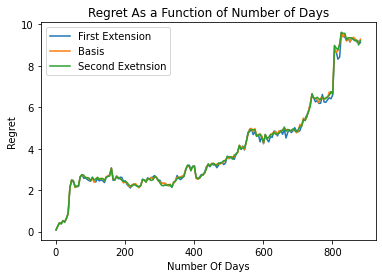

In [75]:
plt.title('Regret As a Function of Number of Days')
plt.plot(days, regrets_basis, label='First Extension')
plt.plot(days, regrets_extended, label='Basis')
plt.plot(days, regrets_extended2, label ='Second Exetnsion')
plt.xlabel('Number Of Days')
plt.legend()
plt.ylabel('Regret')
plt.show()